SLaM (Source, Light and Mass): Mass Total + Subhalo NFW + Source Parametric
===========================================================================

SLaM pipelines break the analysis down into multiple pipelines which focus on modeling a specific aspect of the strong
lens, first the Source, then the (lens) Light and finally the Mass. Each of these pipelines has it own inputs which
which customize the model and analysis in that pipeline.

The models fitted in earlier pipelines determine the model used in later pipelines. For example, if the SOURCE PIPELINE
uses a parametric `EllSersic` profile for the bulge, this will be used in the subsequent MASS TOTAL PIPELINE.

Using a SOURCE PARAMETRIC PIPELINE, MASS TOTAL PIPELINE and SUBHALO PIPELINE this SLaM script fits `Imaging` of a strong lens
system, where in the final model:

 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllIsothermal`.
 - A dark matter subhalo near The lens galaxy mass is included as a`SphNFWMCRLudLow`.
 - The source galaxy is an `EllSersic`.

This uses the SLaM pipelines:

 `source_parametric/no_lens_light`
 `mass_total/no_lens_light`
 `subhalo/detection_single_plane`

Check them out for a full description of the analysis!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import os
import sys
from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

sys.path.insert(0, os.getcwd())
import slam

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

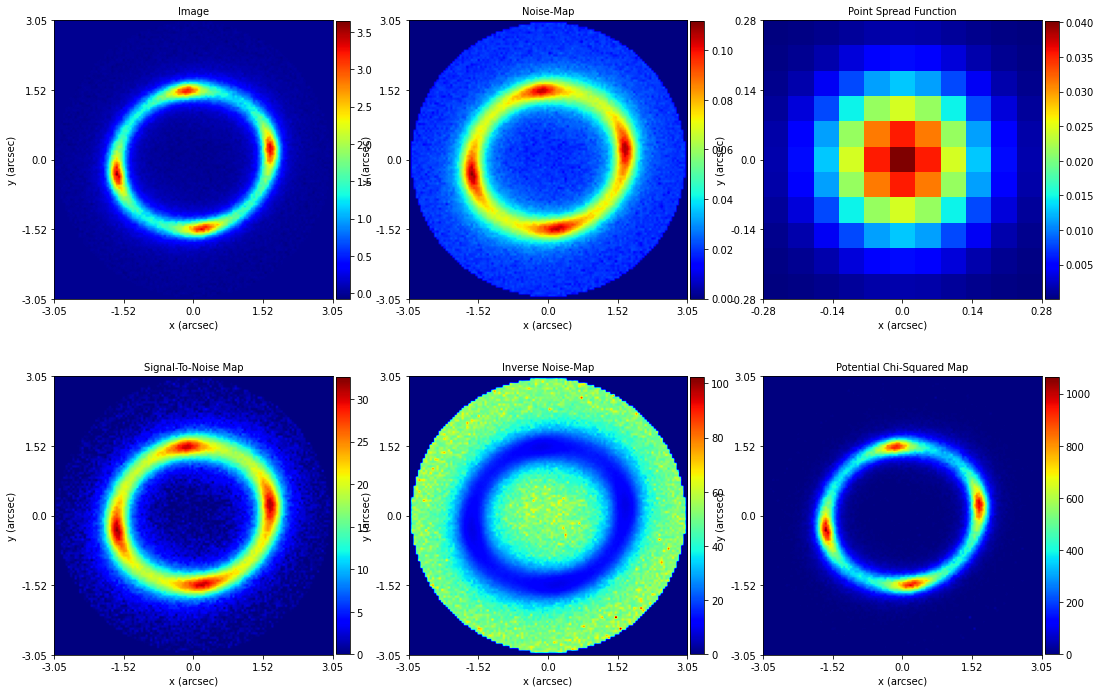

In [2]:
dataset_name = "mass_sie__subhalo_nfw__source_sersic"
dataset_path = path.join("dataset", "imaging", "subhalo", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "slam", dataset_name)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__HYPER SETUP__

The `SetupHyper` determines which hyper-mode features are used during the model-fit.

In [5]:
setup_hyper = al.SetupHyper(
    hyper_galaxies_lens=False,
    hyper_galaxies_source=False,
    hyper_image_sky=None,
    hyper_background_noise=None,
)

__SOURCE PARAMETRIC PIPELINE (no lens light)__

The SOURCE PARAMETRIC PIPELINE (no lens light) uses one search to initialize a robust model for the source galaxy's 
light, which in this example:

 - Uses a parametric `EllSersic` bulge for the source's light (omitting a disk / envelope).
 - Uses an `EllIsothermal` model for the lens's total mass distribution with an `ExternalShear`.
 
 __Settings__:
 
 - Mass Centre: Fix the mass profile centre to (0.0, 0.0) (this assumption will be relaxed in the MASS TOTAL PIPELINE).

In [6]:
analysis = al.AnalysisImaging(dataset=imaging)

source_parametric_results = slam.source_parametric.no_lens_light(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    mass=af.Model(al.mp.EllIsothermal),
    shear=af.Model(al.mp.ExternalShear),
    source_bulge=af.Model(al.lp.EllSersic),
    mass_centre=(0.0, 0.0),
    redshift_lens=0.5,
    redshift_source=1.0,
)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.43it/s, +200 | bound: 0 | nc: 1 | ncall: 202 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.209]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__MASS TOTAL PIPELINE (no lens light)__

The MASS TOTAL PIPELINE (no lens light) uses one search to fits a complex lens mass model to a high level of accuracy, 
using the lens mass model and source model of the SOURCE PIPELINE to initialize the model priors. In this example it:

 - Uses an `EllPowerLaw` model for the lens's total mass distribution [The centre if unfixed from (0.0, 0.0)].
 - Uses the `EllSersic` model representing a bulge for the source's light.
 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PIPELINE through to the MASS TOTAL PIPELINE.

In [7]:
analysis = al.AnalysisImaging(dataset=imaging)

mass_results = slam.mass_total.no_lens_light(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_parametric_results,
    mass=af.Model(al.mp.EllPowerLaw),
)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 50.40it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__SUBHALO PIPELINE (single plane detection)__

The SUBHALO PIPELINE (single plane detection) consists of the following searches:
 
 1) Refit the lens and source model, to refine the model evidence for comparing to the models fitted which include a 
 subhalo. This uses the same model as fitted in the MASS TOTAL PIPELINE. 
 2) Performs a grid-search of non-linear searches to attempt to detect a dark matter subhalo. 
 3) If there is a successful detection a final search is performed to refine its parameters.
 
For this runner the SUBHALO PIPELINE customizes:

 - The [number_of_steps x number_of_steps] size of the grid-search, as well as the dimensions it spans in arc-seconds.
 - The `number_of_cores` used for the gridsearch, where `number_of_cores > 1` performs the model-fits in paralle using
 the Python multiprocessing module.

In [8]:
analysis = al.AnalysisImaging(dataset=imaging)

subhalo_results = slam.subhalo.detection_single_plane(
    path_prefix=path_prefix,
    analysis=analysis,
    setup_hyper=setup_hyper,
    mass_results=mass_results,
    subhalo_mass=af.Model(al.mp.SphNFWMCRLudlow),
    grid_dimension_arcsec=3.0,
    number_of_steps=5,
)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 56.11it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty 

Finish.